In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report




import tensorflow 



In [23]:
# CODE TO VISUALIZE RESULTS VIA CONFUSION MATRIX, FRAUD CHARTS AND CHART FOR DIFFERENCE BETWEEN PREDICTED AND TRUE VALUES

In [4]:
class Visualization:
    labels = ["Normal", "Fraud"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Fraud" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Fraudulent")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()


In [ ]:
# READING OUR DATA

In [5]:

df = pd.read_csv('creditcard.csv', header=0, sep=',')
print(df.shape[0])
df.head()


11959


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


In [ ]:
#I will collect 20k normal and 400 fraudulent records. I can pick different ratios
#to try, but in general more normal data examples are better because I want to teach
#the autoencoder what normal data looks like. Too much fraudulent data in training
#will train the autoencoder to learn that the fraudulent records are actually normal, which goes
#against my goal.

In [8]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000, replace=True)
df1 = df.query('Class == 1').sample(400, replace=True)
df = pd.concat([df0, df1])


In [ ]:
# Splitting the Data

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')


(16320, 29) train samples
(4080, 29) test samples


In [ ]:
# Creatiing Simple Auto Emcoder Neural Network

In [10]:
#simple autoencoder
logfilename = "simpleautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 12)                360       
                                                                 
 dense_1 (Dense)             (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [11]:
#sparse autoencoder
logfilename = "sparseautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu',
               activity_regularizer=regularizers.l1(10e-5))(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_2 (Dense)             (None, 12)                360       
                                                                 
 dense_3 (Dense)             (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [12]:
#deep autoencoder
logfilename = "deepautoencoder"

encoding_dim = 16
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_4 (Dense)             (None, 16)                480       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 8)                 40        
                                                                 
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 29)                493 

In [13]:
autoencoder.compile(optimizer=RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [14]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='../logs/{0}'.format(logfilename))])


Epoch 1/20
510/510 [==============================] - 4s 5ms/step - loss: 1.7173 - mae: 0.7493 - accuracy: 0.1804 - val_loss: 1.8159 - val_mae: 0.7489 - val_accuracy: 0.3461
Epoch 2/20
510/510 [==============================] - 2s 4ms/step - loss: 1.6804 - mae: 0.7399 - accuracy: 0.4067 - val_loss: 1.7973 - val_mae: 0.7441 - val_accuracy: 0.4939
Epoch 3/20
510/510 [==============================] - 1s 3ms/step - loss: 1.6707 - mae: 0.7375 - accuracy: 0.5029 - val_loss: 1.7939 - val_mae: 0.7433 - val_accuracy: 0.5255
Epoch 4/20
510/510 [==============================] - 1s 3ms/step - loss: 1.6683 - mae: 0.7370 - accuracy: 0.5250 - val_loss: 1.7920 - val_mae: 0.7429 - val_accuracy: 0.5429
Epoch 5/20
510/510 [==============================] - 1s 3ms/step - loss: 1.6666 - mae: 0.7366 - accuracy: 0.5388 - val_loss: 1.7906 - val_mae: 0.7426 - val_accuracy: 0.5559
Epoch 6/20
510/510 [==============================] - 2s 3ms/step - loss: 1.6654 - mae: 0.7363 - accuracy: 0.5561 - val_loss: 1.78

In [15]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 [==============================] - 0s 2ms/step - loss: 1.7834 - mae: 0.7414 - accuracy: 0.6402
Test loss: 1.7833548784255981
Test accuracy: 0.741369903087616


In [16]:
threshold=15.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)



128/128 [==============================] - 0s 2ms/step


In [17]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3987
         1.0       0.69      0.80      0.74        93

    accuracy                           0.99      4080
   macro avg       0.84      0.89      0.87      4080
weighted avg       0.99      0.99      0.99      4080



In [18]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3987
         1.0       0.69      0.80      0.74        93

    accuracy                           0.99      4080
   macro avg       0.84      0.89      0.87      4080
weighted avg       0.99      0.99      0.99      4080



In [19]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3987
         1.0       0.69      0.80      0.74        93

    accuracy                           0.99      4080
   macro avg       0.84      0.89      0.87      4080
weighted avg       0.99      0.99      0.99      4080



In [20]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3987
         1.0       0.69      0.80      0.74        93

    accuracy                           0.99      4080
   macro avg       0.84      0.89      0.87      4080
weighted avg       0.99      0.99      0.99      4080



In [21]:
roc_auc_score(y_test, y_label)

0.8937110124032136

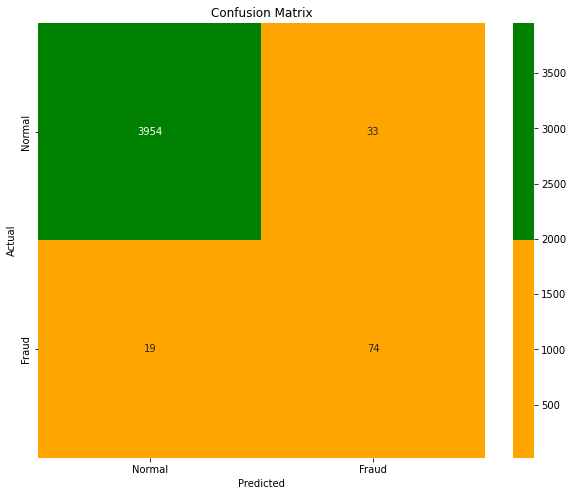

In [22]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

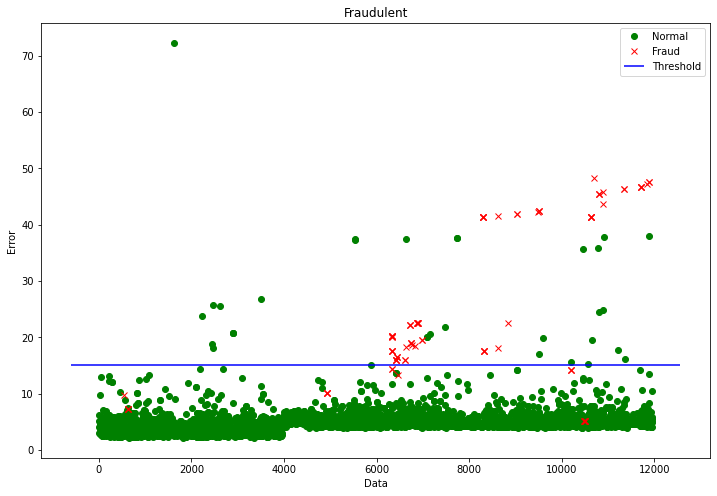

In [23]:
viz.draw_anomaly(y_test, error, threshold)